In [3]:
import pandas as pd
import os
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [4]:
def plotdata(filename='./sim_perf.txt', ttl=''):
    sd = pd.read_csv(filename, sep=';')
    sd['loss'] = sd['loss'].astype(float)
    sd['epsilon'] = sd['epsilon'].astype(float)
    plt.figure(figsize=(16, 8))
    plt.title(ttl)
    plt.plot(sd['epoch'], sd['rougeF1'], c='blue', label='F1')
#     plt.plot(sd['epoch'], sd['rougePrecision'], c='green', label='Precision')
    plt.plot(sd['epoch'], sd['rougeRecall'], c='purple', label='Recall')
#     plt.plot(sd['epoch'], sd['loss'], c='red')
#     plt.plot(sd['epoch'], sd['epsilon'], c='gray')
#     plt.ylim([0,1])
    plt.ylabel("Rouge, Loss, & Epsilon value")
    plt.xlabel("Training Epoch")
    plt.legend()
    plt.grid()
    plt.show()
    plt.figure(figsize=(16, 4))
    plt.plot(sd['epoch'], sd['loss'], c='red')
    plt.grid()
    plt.show()
    return sd

# New experiments on 100 records

In [22]:
! time th testModel.lua --nepochs 200 --gamma 0 \
    --learning_rate 1e-3 --cuts 20 --n_rand 0 \
    --edim 100 --mem_size 3000 --metric recall --n_samples 100

...Utils file loaded	
Running bag-of-words model to learn recall	
...running on CPU	

real	11m56.276s
user	11m44.254s
sys	0m5.010s


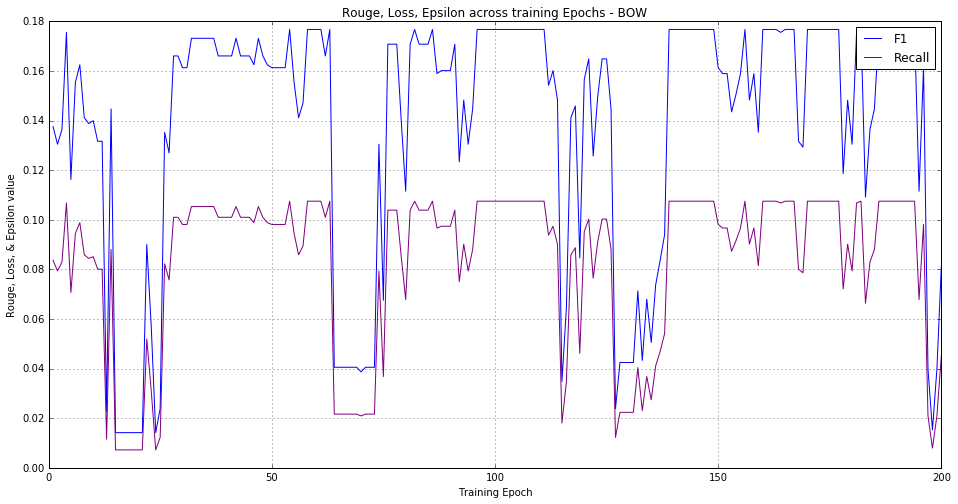

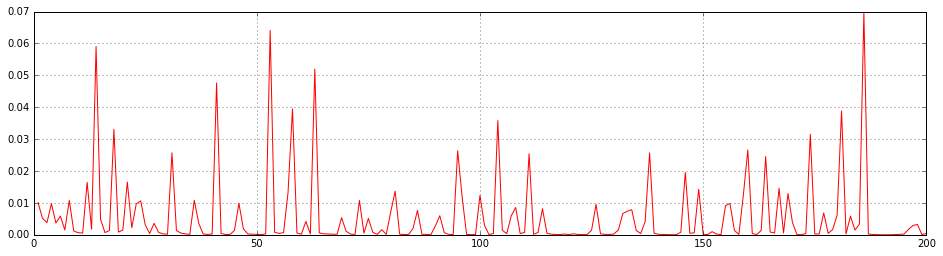

In [23]:
_ = plotdata('./perf.txt', 'Rouge, Loss, Epsilon across training Epochs - BOW')

In [26]:
! time th testModel.lua --nepochs 200 --gamma 0 \
    --learning_rate 1e-4 --cuts 20 --n_rand 0 \
    --edim 100 --mem_size 3000 --metric recall --n_samples 100

...Utils file loaded	
Running bag-of-words model to learn recall	
...running on CPU	

real	11m51.121s
user	11m42.917s
sys	0m3.796s


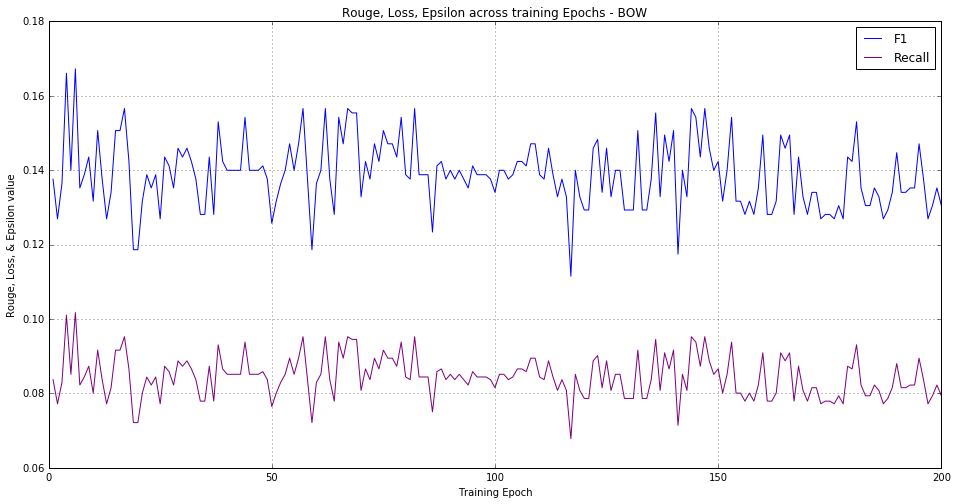

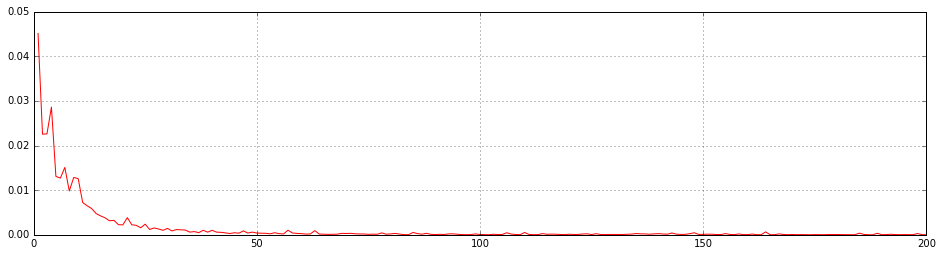

In [27]:
_ = plotdata('./perf.txt', 'Rouge, Loss, Epsilon across training Epochs - BOW')

In [ ]:
! time th testModel.lua --nepochs 200 --gamma 0 \
    --learning_rate 1e-5 --cuts 20 --n_rand 0 \
    --edim 100 --mem_size 3000 --metric recall --n_samples 100

...Utils file loaded	
Running bag-of-words model to learn recall	
...running on CPU	


In [ ]:
_ = plotdata('./perf.txt', 'Rouge, Loss, Epsilon across training Epochs - BOW')

In [ ]:
! time th testModel.lua --nepochs 200 --gamma 0 \
    --learning_rate 1e-5 --cuts 20 --n_rand 0 \
    --edim 100 --mem_size 5000 --metric recall --n_samples 100

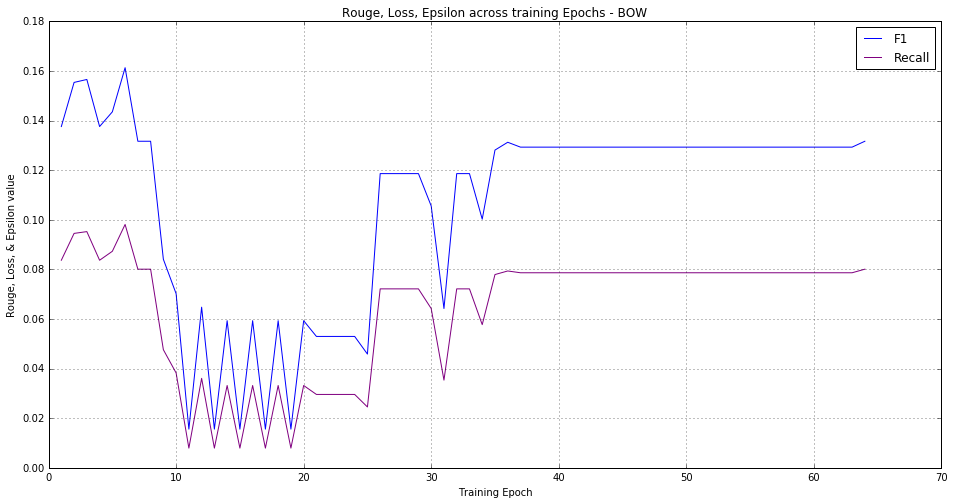

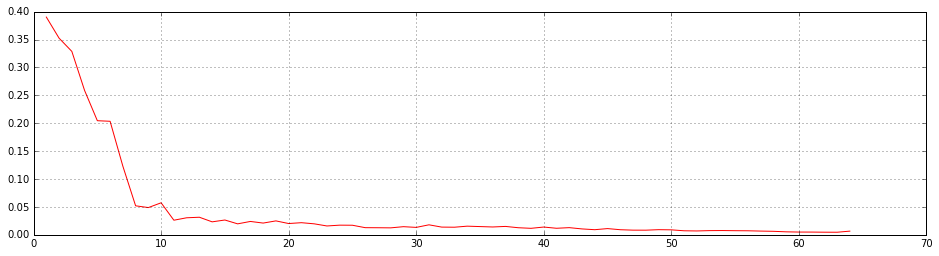

In [31]:
_ = plotdata('./perf.txt', 'Rouge, Loss, Epsilon across training Epochs - BOW')

# Increasing up to 500 records

In [18]:
! time th testModel.lua --nepochs 200 --gamma 0 \
    --learning_rate 1e-5 --cuts 20 --n_rand 0 \
    --edim 100 --mem_size 5000 --metric recall --n_samples 500

...Utils file loaded	
Running bag-of-words model to learn recall	
...running on CPU	

real	21m11.319s
user	20m59.933s
sys	0m5.925s


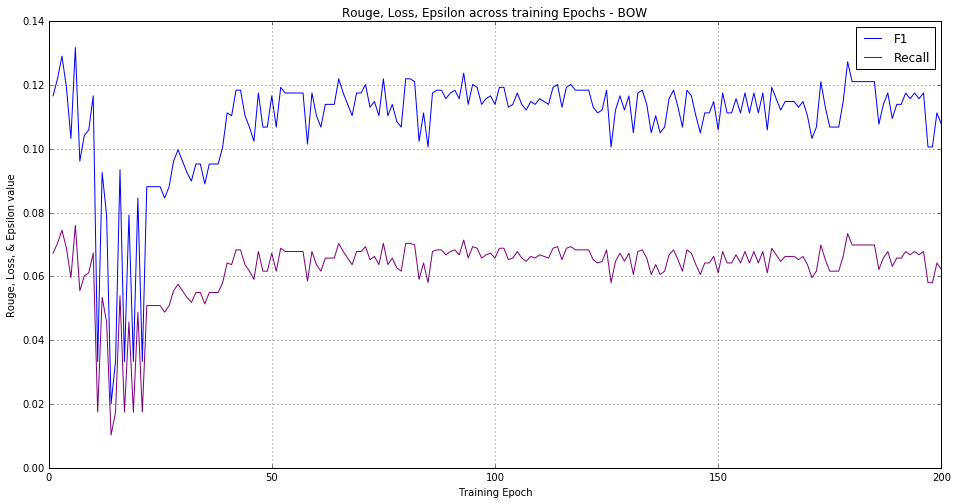

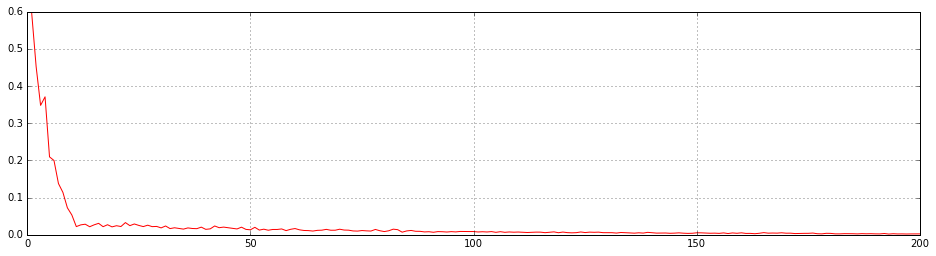

In [19]:
_ = plotdata('./perf.txt', 'Rouge, Loss, Epsilon across training Epochs - BOW')

In [ ]:
! time th testModel.lua --nepochs 200 --gamma 0 \
    --learning_rate 1e-5 --cuts 20 --n_rand 0 \
    --edim 100 --mem_size 5000 --metric recall

In [ ]:
_ = plotdata('./perf.txt', 'Rouge, Loss, Epsilon across training Epochs - BOW')